In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction/sample_submission.csv
/kaggle/input/car-price-prediction/car_links.csv
/kaggle/input/car-price-prediction/auto_df.csv
/kaggle/input/car-price-prediction/test.csv


<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


In [2]:
'''Импортируем все необходимые библиотеки и инструменты для выполнения проекта'''
import numpy as np
import pandas as pd
import sys
pd.options.display.max_seq_items = None
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import warnings; warnings.simplefilter('ignore')
import ast
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Setup

In [3]:
VERSION    = 16
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

'''Определяем функцию MAPE'''

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5


# Parsing

In [4]:
'''Код парсинга закоментирован, поскольку выполнялся на компьютере перед составлением Kaggle ноутбука'''

'''знакомимся с тестовыми данными, которые нам уже даны, для того, 
        чтобы собрать корректный файл с auto.ru'''

#test = pd.read_csv('../input/car-price-prediction/test.csv')
#test.info()

'знакомимся с тестовыми данными, которые нам уже даны, для того, \n        чтобы собрать корректный файл с auto.ru'

In [5]:
'''Cоставляем список URL адресов, с которых нам необходимо
спарсить данные внутри каждого бренда, представленного в тестовом датасете'''

# brands=(data.brand.unique()).tolist()
# url = 'https://auto.ru/moskva/cars/'
# cars_urls=[]
# brand_urls=[]
# for brand in brands:
#     brand_url = url + brand + '/used/?page='
#     for number in range(1, 100):
#         response = requests.get(brand_url+str(number), headers={'User-Agent': 'Mozilla/5.0'})
#         page = BeautifulSoup(response.text, 'html.parser')
#         link_list = page.find_all('a', class_='Link ListingItemTitle-module__link')
#         if len(link_list) !=0:
#             for link in link_list:
#                 cars_urls.append(link['href'])
#         else:
#             break
#pd.Series(cars_urls).to_csv('car_links.csv', index=False)

'Cоставляем список URL адресов, с которых нам необходимо\nспарсить данные внутри каждого бренда, представленного в тестовом датасете'

In [6]:
'''Устанавливаем scrapy для парсинга данных и пишем код для spider'''

#Код для spider
# import scrapy
# import pandas as pd
# import numpy as np
# import json
# import time


# class CarSpider(scrapy.Spider):
#     name = 'auto'
#     start_urls = list(pd.read_csv('car_links.csv').values.flatten())

#     def parse(self, response):
#         data = {}
#         script=response.xpath('//script[@id="initial-state"]//text()').get()
#         script2=response.xpath('//script[@type="application/ld+json"]//text()').get()   
#         json_data=json.loads(script)
#         json_data2=json.loads(script2)     


#         try:
#             data['bodyType'] = json_data2['bodyType']
#         except KeyError:
#             data['bodyType'] = np.nan       
#         try:
#             data['brand'] = json_data2['brand']
#         except KeyError:
#             data['brand'] = np.nan
#         data['car_url'] = response.url 
#         try:
#             data['color'] = json_data2['color']
#         except KeyError:
#             data['color'] = np.nan             
#         try:
#             data['complectation_dict'] = json_data['card']['vehicle_info']['complectation']['available_options']
#         except KeyError:
#             data['complectation_dict'] = np.nan
#         try:
#             data['description'] = json_data2['description']
#         except KeyError:
#             data['description'] = np.nan
#         try:
#             data['engineDisplacement'] = json_data2['vehicleEngine']['engineDisplacement']
#         except KeyError:
#             data['engineDisplacement'] = np.nan       
#         try:
#             data['enginePower'] = json_data2['vehicleEngine']['enginePower']
#         except KeyError:
#             data['enginePower'] = np.nan 
#         try:
#             data['equipment_dict'] = json_data['card']['vehicle_info']['equipment']
#         except KeyError:
#             data['equipment_dict'] = np.nan
#         try:
#             data['fuelType'] = json_data2['vehicleEngine']['fuelType']
#         except KeyError:
#             data['fuelType'] = np.nan
#         try:
#             data['image'] = json_data2['image']
#         except KeyError:
#             data['image'] = np.nan
#         try:
#             data['mileage'] = json_data['card']['state']['mileage']
#         except KeyError:
#             data['mileage'] = np.nan                
#         try:
#             data['modelDate'] = json_data2['modelDate']
#         except KeyError:
#             data['modelDate'] = np.nan
#         try:
#             data['model_info'] = json_data['card']['vehicle_info']['model_info']
#         except KeyError:
#             data['model_info'] = np.nan
#         try:
#             data['model_name'] = json_data2['name']
#         except KeyError:
#             data['model_name'] = np.nan
#         try:
#             data['name'] = json_data2['vehicleEngine']['name']
#         except KeyError:
#             data['name'] = np.nan
#         try:
#             data['numberOfDoors'] = json_data2['numberOfDoors']
#         except KeyError:
#             data['numberOfDoors'] = np.nan
#         data['parsing_unixtime'] = int(time.time())
#         try:
#             data['priceCurrency'] = json_data2['offers']['priceCurrency']
#         except KeyError:
#             data['priceCurrency'] = np.nan
#         try:
#            data['productionDate'] = json_data2['productionDate']
#         except KeyError:
#            data['productionDate'] = np.nan       
#         data['sell_id'] = response.css("div[title='Идентификатор объявления']::text").get()
#         try:
#             data['super_gen'] = json_data['card']['vehicle_info']['tech_param']
#         except KeyError:
#             data['super_gen'] = np.nan
#         try:
#             data['vehicleConfiguration'] = json_data2['vehicleConfiguration']
#         except KeyError:
#             data['vehicleConfiguration'] = np.nan 
#         try:
#             data['vehicleTransmission'] = json_data2['vehicleTransmission']
#         except KeyError:
#             data['vehicleTransmission'] = np.nan 
#         try:
#             data['vendor'] = json_data['card']['vehicle_info']['vendor']
#         except KeyError:
#             data['vendor'] = np.nan
#         try:
#             data['Владельцы'] = response.css("li[class='CardInfoRow CardInfoRow_ownersCount'] span::text").getall()[-1]
#         except IndexError:
#             data['Владельцы'] = np.nan
#         try:
#             data['Владение'] = response.css("li[class='CardInfoRow CardInfoRow_owningTime'] span::text").getall()[-1]
#         except IndexError:
#             data['Владение'] = np.nan
#         try:
#             data['ПТС'] = json_data['card']['documents']['pts']
#         except KeyError:
#             data['ПТС'] = np.nan
#         try:
#             data['Привод'] = json_data['card']['vehicle_info']['tech_param']['gear_type']
#         except KeyError:
#             data['Привод'] = np.nan
#         try:
#             data['Руль'] = json_data['card']['vehicle_info']['steering_wheel']
#         except KeyError:
#             data['Руль'] = np.nan
#         try:
#             data['Состояние'] = json_data['card']['state']['state_not_beaten']
#         except KeyError:
#             data['Состояние'] = np.nan
#         try:
#             data['Таможня'] = json_data['card']['documents']['custom_cleared']
#         except KeyError:
#             data['Таможня'] = np.nan
#         try:
#             data['price'] = json_data2['offers']['price']
#         except KeyError:
#             data['price'] = np.nan

#         yield data

'''Запускаем spider auto.py'''
#!scrapy crawl auto -o auto_df.csv

'Запускаем spider auto.py'

In [7]:
'''Проверяем, что колонки соответствуют файлу test, а также есть дополнительный столбец price'''

#train = pd.read_csv('../input/car-price-prediction/auto_df.csv')
#train.info()

'Проверяем, что колонки соответствуют файлу test, а также есть дополнительный столбец price'

# Data

In [8]:
'''Вызываем датасеты для работы:
1) Спарсенный датасет для обучения модели
2) Тестовый датасет для валидации модели
3) Форма подгрузки результатов в соревнование на Kaggle'''

train = pd.read_csv('../input/car-price-prediction/auto_df.csv')
test = pd.read_csv('../input/car-price-prediction/test.csv')
sample_submission = pd.read_csv('../input/car-price-prediction/sample_submission.csv')

# Data Preprocessing


In [9]:
'''Обрабатываем тренировочные данные, убираем строки с пропусками в целевой переменной
        и строчки с дубликатами по sell_id '''

train = train[train['price'].notna()]
train = train.drop_duplicates(subset=['sell_id'])

In [10]:
'''Разворачиваем словари complectation_dict и equipment_dict'''

test['complectation_dict'] = test['complectation_dict'].apply(
    lambda x: [] if pd.isna(x) else json.loads(x)['available_options'])
train['complectation_dict'] = train['complectation_dict'].fillna('')
train['complectation_dict'] = train['complectation_dict'].apply(
    lambda x: x.split(','))

train.equipment_dict = train.equipment_dict.apply(
    lambda x: np.nan if x == '{}' else x)
train.equipment_dict = train.equipment_dict.str.replace("'", "\"")
train.equipment_dict = train.equipment_dict.apply(
    lambda x: {'no_dict': True} if pd.isna(x) else ast.literal_eval(x))
test.equipment_dict = test.equipment_dict.apply(
    lambda x: {"no_dict": True} if pd.isna(x) else json.loads(x))

equipment_train = pd.DataFrame.from_dict(train['equipment_dict'])
equipment_train_expand = equipment_train.equipment_dict.apply(pd.Series)
equipment_train_expand_fillNaN = equipment_train_expand.fillna(int(0))
train_equip_df = equipment_train_expand_fillNaN.replace(True, int(1))

equipment_test = pd.DataFrame.from_dict(test['equipment_dict'])
equipment_test_expand = equipment_test.equipment_dict.apply(pd.Series)
equipment_test_expand_fillNaN = equipment_test_expand.fillna(int(0))
test_equip_df = equipment_test_expand_fillNaN.replace(True, int(1))

equipment_df = pd.concat(
    [train_equip_df, test_equip_df], axis=0, ignore_index=True)
equipment_data = pd.DataFrame(equipment_df)
equipment_data.dropna(axis=1, inplace=True)

In [11]:
'''Объединяем данные для обработки полного датасета'''

train['Train'] = 1 
test['Train'] = 0
test['price'] = 0
df_input = train.append(test, sort=False).reset_index(drop=True)
df_input = pd.concat([df_input, equipment_data], axis=1, join="inner")
df_input.isnull().sum()

bodyType                         1
brand                            0
car_url                          0
color                            0
complectation_dict               0
                                ..
advanced-frontlighting-system    0
parktronik                       0
seats-9                          0
24-inch-wheels                   0
23-inch-wheels                   0
Length: 231, dtype: int64

In [12]:
'''Определеяем функцию, которая исправит остальные неточности в данных'''


def preproc_data(df_input):

    df_output = df_input.copy()

    #################### Предобработка ##############################################################
    df_output.columns = ['body_type', 'brand', 'car_url', 'color', 'complectation_dict',
                         'description', 'engine_displacement', 'engine_power', 'equipment_dict',
                         'fuel_type', 'image', 'mileage', 'model_date', 'model_info', 'model_name',
                         'name', 'number_of_doors', 'parsing_unixtime', 'price_currency',
                         'production_date', 'sell_id', 'super_gen', 'vehicle_configuration',
                         'vehicle_transmission', 'vendor', 'owners', 'ownership', 'PTS',
                         'drive', 'driving_wheel', 'status', 'customs', 'price', 'Train',
                         'cruise-control', 'tinted-glass', 'esp', 'usb', 'multi-wheel',
                         'heated-wash-system', 'ashtray-and-cigarette-lighter',
                         'airbag-passenger', 'front-centre-armrest', 'apple-carplay',
                         'roof-rails', 'decorative-interior-lighting', 'isofix-front', 'lock',
                         'rear-camera', 'door-sill-panel', 'servo',
                         'steering-wheel-gear-shift-paddles', 'electro-mirrors',
                         'electro-window-back', '18-inch-wheels', 'mirrors-heat',
                         'body-mouldings', 'dark-interior', 'park-assist-f', 'combo-interior',
                         'rear-seats-heat', 'cooling-box', 'led-lights', 'driver-seat-memory',
                         'sport-pedals', 'park-assist-r', 'engine-proof', 'glonass',
                         'airbag-driver', 'aux', 'isofix', 'electro-window-front',
                         'drive-mode-sys', 'light-sensor', 'airbag-curtain',
                         'passenger-seat-updown', 'collision-prevention-assist', 'computer',
                         'keyless-entry', 'seat-transformation', 'android-auto', 'light-cleaner',
                         'driver-seat-electric', 'alloy-wheel-disks', 'ptf',
                         'leather-gear-stick', 'start-button', 'rain-sensor', 'seats-5',
                         'airbag-side', 'voice-recognition', 'tyre-pressure', 'audiosystem-cd',
                         'electronic-gage-panel', 'abs', 'bluetooth', 'front-seats-heat',
                         'power-child-locks-rear-doors', 'wheel-leather', 'wheel-configuration2',
                         'wheel-configuration1', 'immo', 'climate-control-2', 'auto-mirrors',
                         '12v-socket', 'third-rear-headrest', 'asr', 'adaptive-light',
                         'audiopreparation', 'auto-park', 'xenon', 'lane-keeping-assist',
                         'navigation', 'folding-front-passenger-seat', 'leather', 'seat-memory',
                         'knee-airbag', 'start-stop-function',
                         'roller-blinds-for-rear-side-windows', 'hcc',
                         'automatic-lighting-control', 'high-beam-assist', 'alarm',
                         'airbag-rear-side', 'blind-spot', 'traffic-sign-recognition',
                         'auto-cruise', 'electro-trunk', 'windscreen-heat', 'spare-wheel', 'bas',
                         'feedback-alarm', 'volume-sensor', '17-inch-wheels', 'condition',
                         'wheel-power', 'fabric-seats', 'steel-wheels', '14-inch-wheels', 'drl',
                         'audiosystem-tv', 'front-seat-support', 'climate-control-1',
                         'driver-seat-updown', '16-inch-wheels', 'wheel-heat', 'no_dict',
                         'armored', 'panorama-roof', 'remote-engine-start', 'music-super',
                         'turnbuckle', 'velvet-seats', 'light-interior', '15-inch-wheels',
                         'sport-seats', 'paint-metallic', 'hatch', 'passenger-seat-electric',
                         'multizone-climate-control', 'front-seats-heat-vent', '360-camera',
                         '220v-socket', 'folding-tables-rear', 'reduce-spare-wheel',
                         'windcleaner-heat', 'programmed-block-heater', 'activ-suspension',
                         'seats-7', 'third-row-seats', '19-inch-wheels', 'wireless-charger',
                         'rear-seat-heat-vent', 'seats-4', 'black-roof', 'eco-leather',
                         'driver-seat-support', 'vsm', 'roller-blind-for-rear-window',
                         'e-adjustment-wheel', 'electro-rear-seat', 'easy-trunk-opening',
                         'alcantara', 'dha', 'entertainment-system-for-rear-seat-passengers',
                         'ya-auto', 'sport-suspension', 'front-camera',
                         'drowsy-driver-alert-system', 'power-latching-doors',
                         'projection-display', 'adj-pedals', 'laser-lights', 'gbo', 'seats-2',
                         'airbrush', 'air-suspension', 'laminated-safety-glass', 'night-vision',
                         'wheel-memory', '13-inch-wheels', 'seats-heat', 'electro-window-all',
                         'passenger-seat-manual', 'halogen', 'driver-seat-manual',
                         'climate-control', 'audiosystem', '20-inch-wheels', 'massage-seats',
                         'body-kit', '21-inch-wheels', '22-inch-wheels', '12-inch-wheels',
                         'seats-6', '6XE', 'PX2', '3L5', '6NQ', 'seats-8', 'electro-seat',
                         'wheel-configuration3', '27-inch-wheels', 'passenger-seat-memory',
                         'climate-control-3', 'immobiliser-not-standard',
                         'advanced-frontlighting-system', 'parktronik', 'seats-9',
                         '24-inch-wheels', '23-inch-wheels']

    df_output.drop(['customs', 'status', 'sell_id', 'car_url',
                    'ownership', 'equipment_dict', 'image', 'price_currency', 'parsing_unixtime'],
                   axis=1, inplace=True)

    df_output['body_type'] = df_output.body_type.fillna(
        df_output['body_type'].mode()[0])
    df_output['fuel_type'] = df_output.fuel_type.fillna(
        df_output['fuel_type'].mode()[0])
    df_output['model_date'] = df_output.model_date.fillna(
        df_output['model_date'].mode()[0])
    df_output['name'] = df_output.name.fillna(df_output['name'].mode()[0])
    df_output['number_of_doors'] = df_output.number_of_doors.fillna(
        df_output['number_of_doors'].mode()[0])
    df_output['vehicle_configuration'] = df_output.vehicle_configuration.fillna(
        df_output['vehicle_configuration'].mode()[0])
    df_output['vehicle_transmission'] = df_output.vehicle_transmission.fillna(
        df_output['vehicle_transmission'].mode()[0])
    df_output['PTS'] = df_output.PTS.fillna(df_output['PTS'].mode()[0])
    df_output['drive'] = df_output.drive.fillna(df_output['drive'].mode()[0])
    df_output['price'] = df_output.price.apply(
        lambda x: np.log(x) if x != 0 else x)
    df_output['price'] = df_output.price.apply(
        lambda x: np.log(x) if x != 0 else x)

    # ################### Feature Engineering ####################################################
    df_output['complectation_dict_length'] = df_output['complectation_dict'].map(
        len)
    df_output['complectation_dict_presence'] = df_output['complectation_dict_length'].apply(
        lambda x: 0 if x == 0 else 1)

    ##################### fix ##############################################################
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in ['model_date', 'number_of_doors', 'production_date', 'mileage']:
        df_output[feature] = df_output[feature].astype('int32')

    # Переводим категориальные признаки в dummy-переменные
    label_encoder = LabelEncoder()

    cat_cols=['body_type', 'brand', 'color','engine_displacement', 'engine_power',
          'fuel_type', 'model_info', 'model_name','name','vehicle_configuration',
          'vehicle_transmission', 'vendor', 'owners', 'PTS','drive', 'driving_wheel']
    
    for feature in cat_cols:
        df_output[feature] = label_encoder.fit_transform(df_output[feature])
    
    df_output=pd.get_dummies(df_output, prefix=cat_cols, columns=cat_cols)

    ##################### Clean ####################################################

    df_output.drop(['description', 'complectation_dict',
                    'super_gen'], axis=1, inplace=True)

    return df_output

In [13]:
'''Почистим датасет для обучения модели'''

data_clean=preproc_data(df_input)
data_clean.isnull().sum()

mileage            0
model_date         0
number_of_doors    0
production_date    0
price              0
                  ..
drive_5            0
driving_wheel_0    0
driving_wheel_1    0
driving_wheel_2    0
driving_wheel_3    0
Length: 8972, dtype: int64

In [14]:
train_data = data_clean.query('Train == 1').drop(['Train'], axis=1)
test_data = data_clean.query('Train == 0').drop(['Train'], axis=1)

y = train_data.price.values 
X = train_data.drop(['price'], axis=1)
Test_data = test_data.drop(['price'], axis=1)

## Train Split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, 
                                                    random_state=RANDOM_SEED)

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Grid Search

In [16]:
 '''Подбираем оптимальные параметры для модели CatBoost'''
    
#best_params_model = CatBoostRegressor()
#grid= {'iterations': [500],
              #'learning_rate': [0.01, 0.1, 0.25, 0.5],
              #'l2_leaf_reg': [1, 3, 5, 10],
              #'depth': np.arange(10, 14),
              #'thread_count': [4]}

#best_params_model.grid_search(grid, X=X, y=y,cv=5) 

#best_params_model.fit(X, y)

#best_params_model.get_params()

'Подбираем оптимальные параметры для модели CatBoost'

## Fit

In [17]:
model = CatBoostRegressor(loss_function='RMSE',
                          thread_count=4,
                          depth=10,
                          l2_leaf_reg=1,
                          iterations=500,
                          learning_rate= 0.25,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
          #cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
        #  plot=True
         )

model.save_model('catboost.model')



0:	learn: 0.0168115	test: 0.0167766	best: 0.0167766 (0)	total: 172ms	remaining: 1m 25s
100:	learn: 0.0036590	test: 0.0043030	best: 0.0043030 (100)	total: 10.1s	remaining: 39.8s
200:	learn: 0.0030296	test: 0.0040144	best: 0.0040144 (200)	total: 19.9s	remaining: 29.6s
300:	learn: 0.0026870	test: 0.0039258	best: 0.0039255 (298)	total: 29.8s	remaining: 19.7s
400:	learn: 0.0024116	test: 0.0038651	best: 0.0038642 (399)	total: 39.9s	remaining: 9.84s
499:	learn: 0.0021704	test: 0.0038332	best: 0.0038332 (499)	total: 49.7s	remaining: 0us

bestTest = 0.003833240132
bestIteration = 499



<AxesSubplot:>

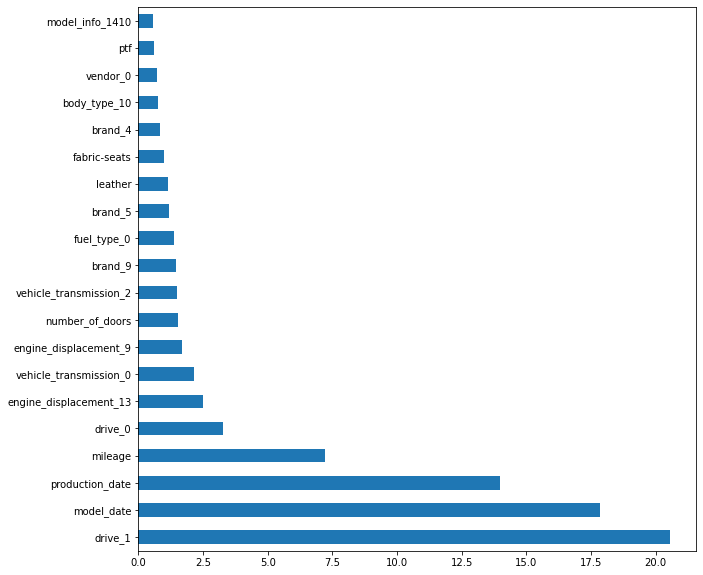

In [18]:
'''Выводим самые важные признаки для модели'''

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# CV

In [19]:
'''Кроссвалидация не дала большей точности на ЛБ, а наоборот ухудшила результат до 23%.
        Привожу код, но в финальной модели использовать не буду'''

# def cat_model(y_train, X_train, X_test, y_test):
#     model = CatBoostRegressor(iterations = ITERATIONS,
#                               learning_rate = LR,
#                               eval_metric='MAPE',
#                               random_seed = RANDOM_SEED,)
#     model.fit(X_train, y_train,
#               #cat_features=cat_features_ids,
#               eval_set=(X_test, y_test),
#               verbose=False,
#               use_best_model=True,
#               plot=False)
    
#     return(model)

'Кроссвалидация не дала большей точности на ЛБ, а наоборот ухудшила результат до 23%.\n        Привожу код, но в финальной модели использовать не буду'

In [20]:
'''Предсказания по каждой модели записывается в submissions'''

# submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) 

# score_ls = []
# splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

# for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
#     # use the indexes to extract the folds in the train and validation data
#     X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
#     # model for this fold
#     model = cat_model(y_train, X_train, X_test, y_test)
#     # score model on test
#     test_predict = model.predict(X_test)
#     test_score = mape(y_test, test_predict)
#     score_ls.append(test_score)
#     print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
#     # submissions
#     submissions[f'sub_{idx+1}'] = np.exp(np.exp(model.predict(Test_data)))
#     model.save_model(f'catboost_fold_{idx+1}.model')
    
# print(f'Mean Score: {np.mean(score_ls):0.3f}')
# print(f'Std Score: {np.std(score_ls):0.4f}')
# print(f'Max Score: {np.max(score_ls):0.3f}')
# print(f'Min Score: {np.min(score_ls):0.3f}')

'Предсказания по каждой модели записывается в submissions'

## ExtraTreeRegressor

In [21]:
'''Пробую обучить другую модель для решения задачи'''

rf = ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

MAPE = mape(y_test, y_pred)
print(f'Mean Absolute Percentage Error: {MAPE}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


Mean Absolute Percentage Error: 0.0040461783756336215


## XGBRegressor

In [22]:
'''Пробую обучить другую модель для решения задачи'''

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.25, max_depth=10, alpha=1,
                          n_estimators=300, silent=1)
xg_reg.fit(X_train, y_train)
xg_red_pred = xg_reg.predict(X_test)

MAPE = mape(y_test, xg_red_pred)
print(f'Mean Absolute Percentage Error: {MAPE}')

[11:43:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Mean Absolute Percentage Error: 0.00432209696861962


## Stacking

In [23]:
'''Объединяем все модели в стек'''

# estimators = [('random_forest', rf),
#               ('catboost', model),
#               ('XGBoost', xg_reg)]

# stack = StackingRegressor(estimators=estimators,
#                           n_jobs=-1,
#                           cv=3,
#                           final_estimator=rf,
#                           verbose=100)

# stack.fit(X_train, y_train).score(X_test, y_test)


# y_pred_stacking = stack.predict(Test_data)

'Объединяем все модели в стек'

# Submission

In [24]:
'''Записываем предсказания для загрузки в соревнование''' 

#sample_submission['price'] = np.exp(np.exp(y_pred_stacking))
# sample_submission.to_csv(f'submission.csv', index=False)
# sample_submission.head(10)

'Записываем предсказания для загрузки в соревнование'